In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
import seaborn as sns

In [2]:
dataset = pd.read_csv("data/joined_dataset.csv")
dataset.head()

,Unnamed: 0.1,Unnamed: 0,month,year,state,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,...,killed_ratio,injured_ratio,arrested_ratio,unharmed_ratio,n_participants,povertyPercentage,party,totalvotes,votes_ratio,population
0,0,0,5,2015.0,Indiana,39.8322,-86.2492,19.00000,19.000000,19.000000,...,0.0,1.0,0.0,0.0,1.0,12.3,DEMOCRAT,112261.000000,0.547323,6611442
1,1,1,4,2017.0,Pennsylvania,41.6645,-78.7856,62.00000,62.000000,62.000000,...,1.0,0.0,0.0,0.0,1.0,10.5,REPUBLICAN,307843.000000,0.671644,12794679
2,2,2,11,2016.0,Michigan,42.4190,-83.0393,28.33336,29.996153,31.800852,...,0.0,0.5,0.0,0.5,2.0,11.0,DEMOCRAT,310974.000000,0.785066,9954117
3,3,3,10,2016.0,District of Columbia,38.9030,-76.9820,28.33336,29.996153,31.800852,...,0.0,0.5,0.0,0.5,2.0,14.9,DEMOCRAT,289939.329727,0.683560,687576
4,4,4,6,2015.0,Pennsylvania,40.4621,-80.0308,28.33336,29.996153,31.800852,...,0.0,0.5,0.0,0.5,2.0,11.5,DEMOCRAT,148351.000000,1.000000,12789838


In [3]:
numeric_dataset = dataset._get_numeric_data()
numeric_dataset.fillna(0, inplace=True)
#numeric_dataset = numeric_dataset[numeric_dataset['latitude'] != 0 ]
#numeric_dataset = numeric_dataset[numeric_dataset['longitude'] < 0 ]
numeric_dataset.head()

,Unnamed: 0.1,Unnamed: 0,month,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,children_ratio,...,females_ratio,killed_ratio,injured_ratio,arrested_ratio,unharmed_ratio,n_participants,povertyPercentage,totalvotes,votes_ratio,population
0,0,0,5,2015.0,39.8322,-86.2492,19.00000,19.000000,19.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,12.3,112261.000000,0.547323,6611442
1,1,1,4,2017.0,41.6645,-78.7856,62.00000,62.000000,62.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,10.5,307843.000000,0.671644,12794679
2,2,2,11,2016.0,42.4190,-83.0393,28.33336,29.996153,31.800852,0.0,...,0.0,0.0,0.5,0.0,0.5,2.0,11.0,310974.000000,0.785066,9954117
3,3,3,10,2016.0,38.9030,-76.9820,28.33336,29.996153,31.800852,0.0,...,0.0,0.0,0.5,0.0,0.5,2.0,14.9,289939.329727,0.683560,687576
4,4,4,6,2015.0,40.4621,-80.0308,28.33336,29.996153,31.800852,0.0,...,0.0,0.0,0.5,0.0,0.5,2.0,11.5,148351.000000,1.000000,12789838


In [4]:
numeric_dataset.drop(numeric_dataset.columns[[0,1]], axis=1, inplace=True)

numeric_dataset.head()

,month,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,children_ratio,teen_ratio,adults_ratio,...,females_ratio,killed_ratio,injured_ratio,arrested_ratio,unharmed_ratio,n_participants,povertyPercentage,totalvotes,votes_ratio,population
0,5,2015.0,39.8322,-86.2492,19.00000,19.000000,19.000000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,12.3,112261.000000,0.547323,6611442
1,4,2017.0,41.6645,-78.7856,62.00000,62.000000,62.000000,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,10.5,307843.000000,0.671644,12794679
2,11,2016.0,42.4190,-83.0393,28.33336,29.996153,31.800852,0.0,0.0,1.0,...,0.0,0.0,0.5,0.0,0.5,2.0,11.0,310974.000000,0.785066,9954117
3,10,2016.0,38.9030,-76.9820,28.33336,29.996153,31.800852,0.0,0.0,1.0,...,0.0,0.0,0.5,0.0,0.5,2.0,14.9,289939.329727,0.683560,687576
4,6,2015.0,40.4621,-80.0308,28.33336,29.996153,31.800852,0.0,0.0,1.0,...,0.0,0.0,0.5,0.0,0.5,2.0,11.5,148351.000000,1.000000,12789838


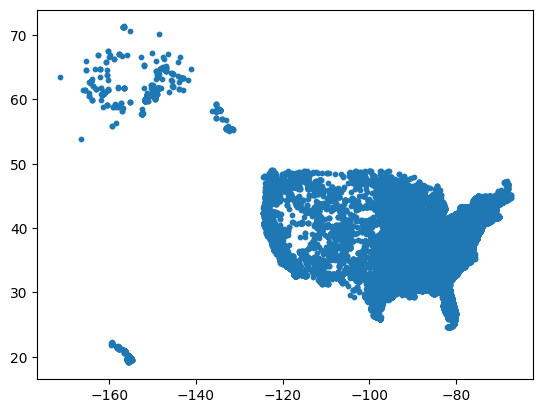

In [5]:
plt.scatter( numeric_dataset['longitude'], numeric_dataset['latitude'], s=10)

In [6]:
numeric_dataset.values.shape

(239677, 21)

In [7]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
print(scaled_dataset.shape)
scaled_dataset[:5]

(239677, 21)


array([[0.36363636, 0.4       , 0.39675713, 0.81779491, 0.18811881,
        0.18811881, 0.18811881, 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.5       , 0.        , 0.42073171, 0.22105823, 0.54732276,
        0.15524022],
       [0.27272727, 0.8       , 0.43184159, 0.8894515 , 0.61386139,
        0.61386139, 0.61386139, 0.        , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.5       , 0.        , 0.31097561, 0.60619105, 0.67164431,
        0.31436246],
       [0.90909091, 0.6       , 0.44628859, 0.84861254, 0.28052832,
        0.29699161, 0.31485992, 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.5       , 0.        ,
        0.75      , 0.00980392, 0.34146341, 0.6123565 , 0.78506563,
        0.24126214],
       [0.81818182, 0.6       , 0.37896502, 0.90676751, 0.28052832,
        0.29699161, 0.31485992, 0.        , 0.       

# K Means

## Identification of the best value of k

In [8]:
sse_list = []
silhoutte_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_dataset)

    sse_list.append(kmeans.inertia_)
    silhoutte_list.append(silhouette_score(scaled_dataset, kmeans.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, kmeans.labels_))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [01:04<00:00,  3.42s/it]


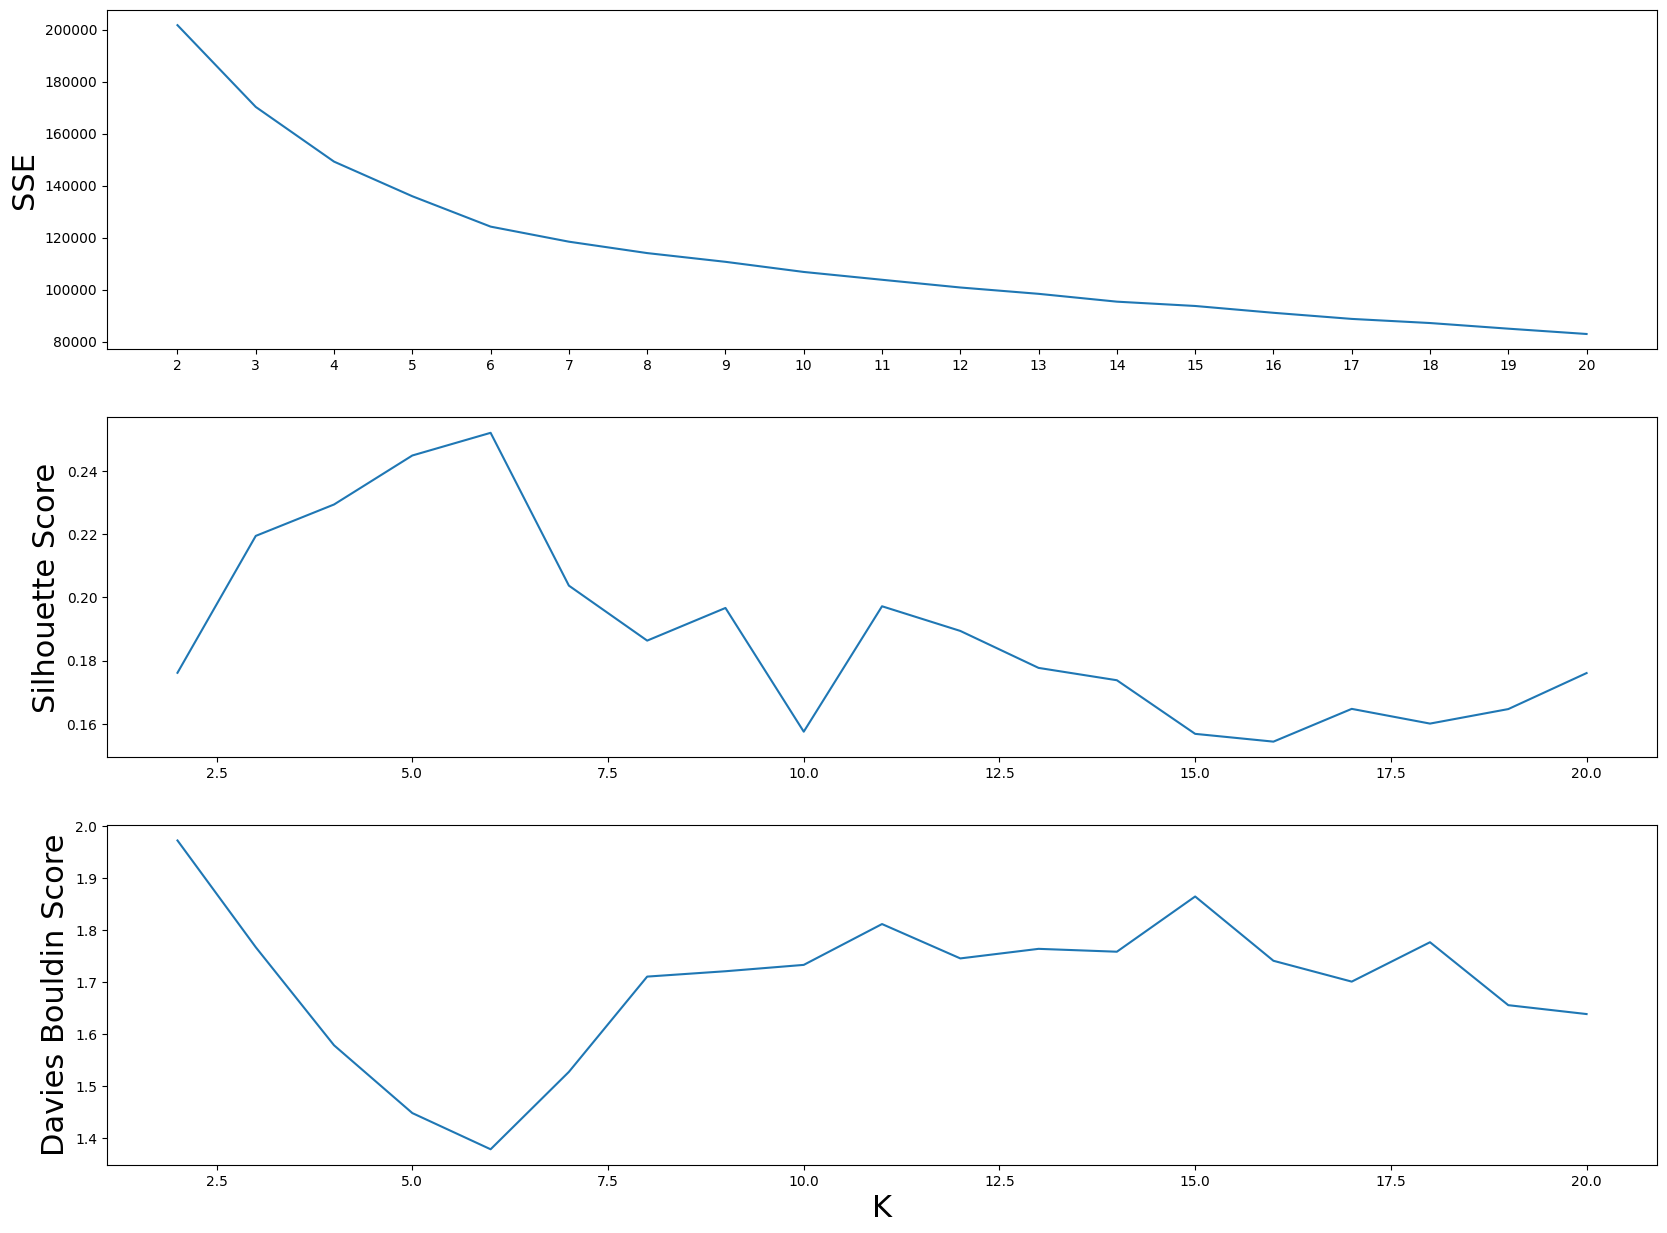

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhoutte_list) + 2), silhoutte_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_xlabel('K', fontsize=22)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)


plt.xlabel('K', fontsize=22)
plt.show()

In [10]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(scaled_dataset)

KMeans(n_clusters=7, n_init=10)

In [11]:
kmeans.cluster_centers_.shape

(7, 21)

In [12]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=numeric_dataset.columns)
centers_df.head(7)

,month,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,children_ratio,teen_ratio,adults_ratio,...,females_ratio,killed_ratio,injured_ratio,arrested_ratio,unharmed_ratio,n_participants,povertyPercentage,totalvotes,votes_ratio,population
0,9.290105,2015.529075,37.748188,-87.831472,27.983804,29.502825,31.131073,0.009908,0.007807,0.982285,...,0.018835,0.020745,0.835636,0.063958,0.079661,1.667812,12.723193,235909.573193,0.698582,1.159143e+07
1,6.337963,2015.824333,37.623206,-88.609972,17.209813,18.375255,19.768071,0.028286,0.836201,0.135513,...,0.066567,0.131965,0.410549,0.309135,0.148351,1.793285,12.596464,244950.811261,0.688899,1.183202e+07
2,6.387995,2015.726939,36.792258,-91.191994,31.344030,33.320545,35.331061,0.008096,0.004113,0.987791,...,0.036647,0.820421,0.012186,0.097680,0.069713,1.546123,12.914960,234391.807005,0.691779,1.319702e+07
3,3.290829,2016.062053,37.485398,-88.586457,28.003573,29.557169,31.216722,0.009007,0.007328,0.983665,...,0.018628,0.022195,0.806047,0.085232,0.086526,1.714606,12.510194,248015.534366,0.694213,1.205594e+07
4,6.360600,2015.737086,37.063757,-90.016480,30.243334,32.703539,35.279727,0.024618,0.019686,0.955696,...,0.697477,0.200836,0.357913,0.243102,0.198148,1.903449,13.007489,240686.029158,0.687842,1.152561e+07
5,6.331901,2015.278231,37.555982,-89.139408,28.459240,30.110601,31.918559,0.005501,0.008248,0.986252,...,0.032167,0.011159,0.031940,0.012913,0.943987,2.163415,13.010612,228086.075176,0.677902,1.116669e+07
6,6.218570,2016.205799,38.341144,-89.875438,28.875509,30.262017,31.904944,0.001837,0.016431,0.981732,...,0.035789,0.020282,0.026527,0.939363,0.013828,1.743092,12.052719,266509.532717,0.659075,1.170429e+07


In [13]:
cluster_num_points = []
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[kmeans.labels_ == i])
    cluster_num_points.append(len(cluster_points[-1]))
    
cluster_num_points, cluster_points[0].shape

([35769, 13462, 34843, 32571, 20271, 63070, 39691], (35769, 21))

In [18]:
kmeans_tot = KMeans(n_clusters=1, n_init=10)
kmeans_tot.fit(scaled_dataset)
total_SSE = kmeans_tot.inertia_ / len(scaled_dataset)

cluster_SSE = []
for i in range(n_clusters):
    cluster_sse = 0
    for point in cluster_points[i]:
        cluster_sse += np.linalg.norm(point - kmeans.cluster_centers_[i])**2
    cluster_SSE.append(cluster_sse / cluster_num_points[i])

print("Cluster SSE: ", cluster_SSE)
print("Total SSE: ", total_SSE)
print("SSE of cluster with min SSE: ", min(cluster_SSE))
print("SSE of cluster with max SSE: ", max(cluster_SSE))
print("Mean of SSE: ", np.mean(cluster_SSE))

Cluster SSE:  [0.3847638536764752, 0.9858944265408788, 0.5386030821161585, 0.41679722613887077, 0.895094284180111, 0.38987456167686313, 0.4305576646299954]
Total SSE:  1.0130020332229828
SSE of cluster with min SSE:  0.3847638536764752
SSE of cluster with max SSE:  0.9858944265408788
Mean of SSE:  0.5773692998513361


In [19]:
cluster_distance_variance = []
total_distance_variance = 0
dataset_centroid = np.mean(scaled_dataset, axis=0)

###### CI RIPENSIAMO SU QUESTO ######
for point in scaled_dataset:
    total_distance_variance += (np.linalg.norm(point - dataset_centroid)**2 - total_SSE) ** 2
total_distance_variance /= len(scaled_dataset)
#####################################

for i in range(n_clusters):
    variance = 0
    for p in cluster_points[i]:
        variance += ((np.linalg.norm(p - kmeans.cluster_centers_[i]))**2 - cluster_SSE[i])**2
    cluster_distance_variance.append(variance/cluster_num_points[i])

print("Cluster distance variance: ", cluster_distance_variance)
print("Total distance variance: ", total_distance_variance)
print("Distance variance of cluster with min SSE: ", min(cluster_distance_variance))
print("Distance variance of cluster with max SSE: ", max(cluster_distance_variance))
print("Mean of distance variance: ", np.mean(cluster_distance_variance))

Cluster distance variance:  [0.08895815057186195, 0.23474342362825915, 0.08551867800285952, 0.09075885119123837, 0.1813900697957461, 0.05861151664293215, 0.0702408460353793]
Total distance variance:  0.3832888931352252
Distance variance of cluster with min SSE:  0.05861151664293215
Distance variance of cluster with max SSE:  0.23474342362825915
Mean of distance variance:  0.11574593369546807


Construct a distance matrix among cluster centroids.

<Axes: >

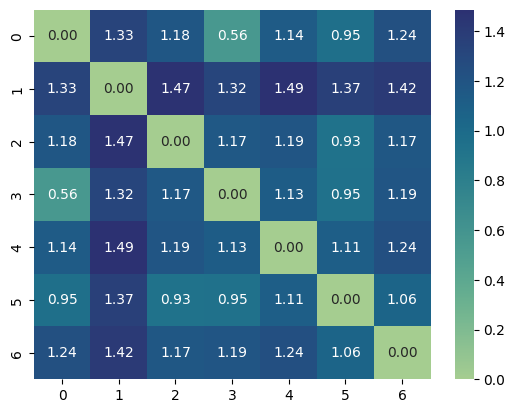

In [16]:
centroid_distance_matrix = squareform(pdist(kmeans.cluster_centers_))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

([<matplotlib.axis.YTick at 0x273801f30>,
 [Text(0, 0.5, 'month'),
  Text(0, 1.5, 'year'),
  Text(0, 2.5, 'latitude'),
  Text(0, 3.5, 'longitude'),
  Text(0, 4.5, 'min_age_participants'),
  Text(0, 5.5, 'avg_age_participants'),
  Text(0, 6.5, 'max_age_participants'),
  Text(0, 7.5, 'children_ratio'),
  Text(0, 8.5, 'teen_ratio'),
  Text(0, 9.5, 'adults_ratio'),
  Text(0, 10.5, 'males_ratio'),
  Text(0, 11.5, 'females_ratio'),
  Text(0, 12.5, 'killed_ratio'),
  Text(0, 13.5, 'injured_ratio'),
  Text(0, 14.5, 'arrested_ratio'),
  Text(0, 15.5, 'unharmed_ratio'),
  Text(0, 16.5, 'n_participants'),
  Text(0, 17.5, 'povertyPercentage'),
  Text(0, 18.5, 'totalvotes'),
  Text(0, 19.5, 'votes_ratio'),
  Text(0, 20.5, 'population')])

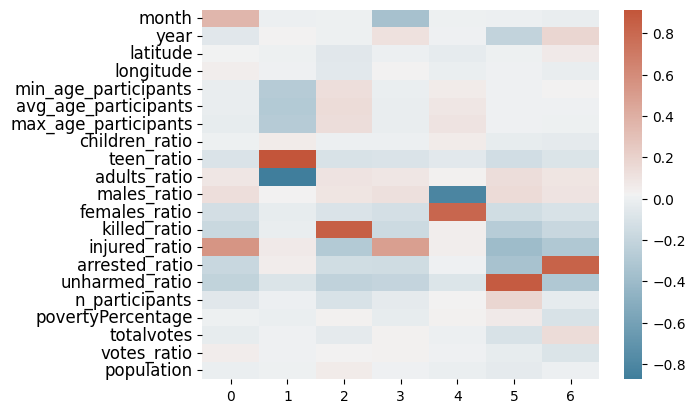

In [25]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(kmeans.labels_), n_clusters))
onehot[np.arange(len(kmeans.labels_)), kmeans.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], fmt = '.2f', cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)


Compute the similarity matrix of a sample of the dataset.

([], [])

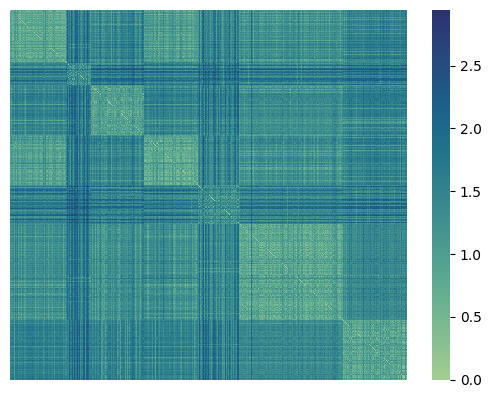

In [39]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = kmeans.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

### Distribution of variables: within clusters vs whole dataset

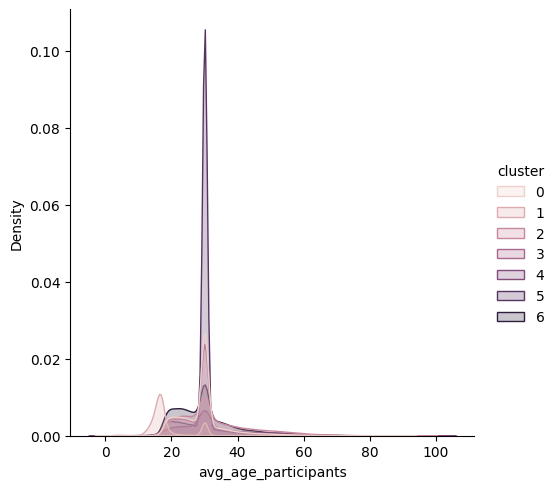

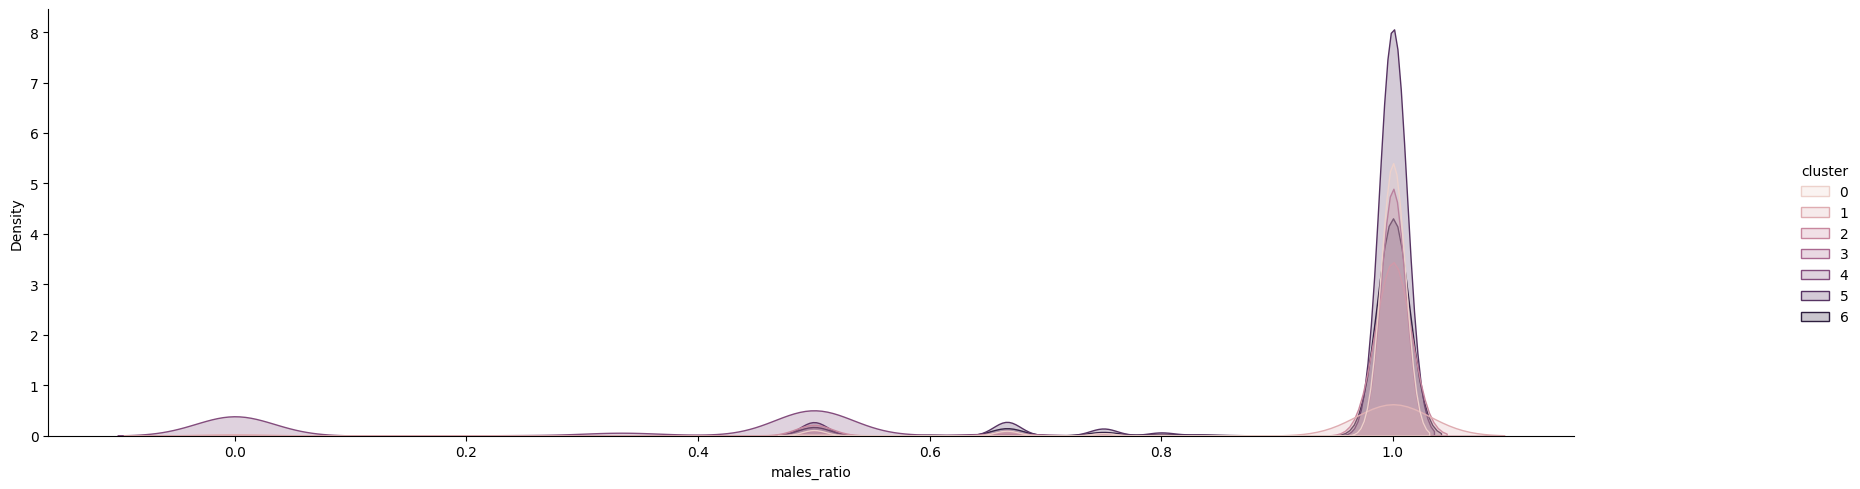

In [61]:
# Plot distribution of average age for whole dataset and clusters
numeric_dataset_with_clusters = numeric_dataset.copy()
numeric_dataset_with_clusters['cluster'] = kmeans.labels_

sns.displot(numeric_dataset_with_clusters, x="avg_age_participants", kind='kde', hue="cluster", fill=True)

sns.displot(numeric_dataset_with_clusters, x="males_ratio", kind='kde', hue="cluster", fill=True)

# Stretch horizontally
plt.gcf().set_size_inches(20, 5)


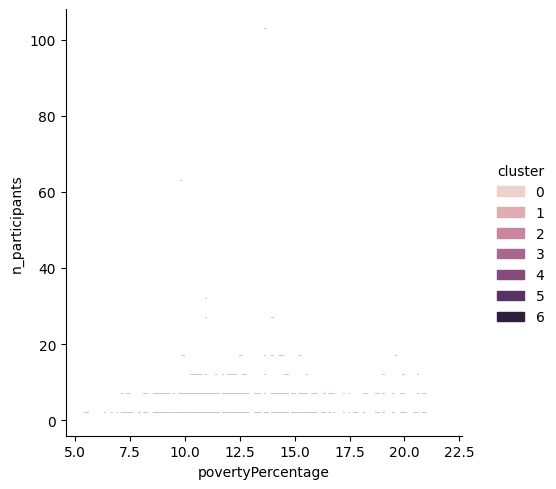

In [66]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', hue="cluster")

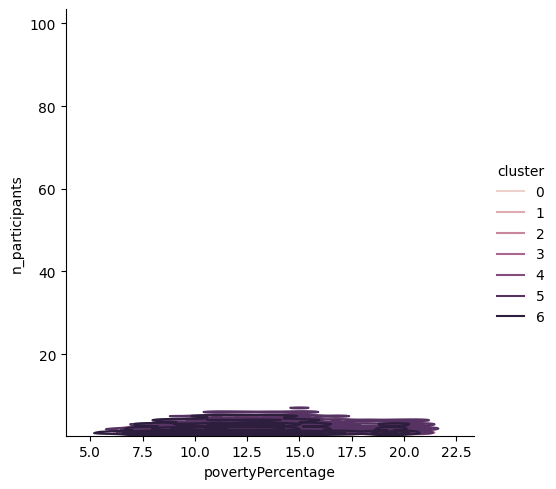

In [67]:
numeric_dataset = numeric_dataset[numeric_dataset['n_participants'] < 20]
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', kind='kde', hue="cluster")
# Restric the plot to number of participants between 0 and 20




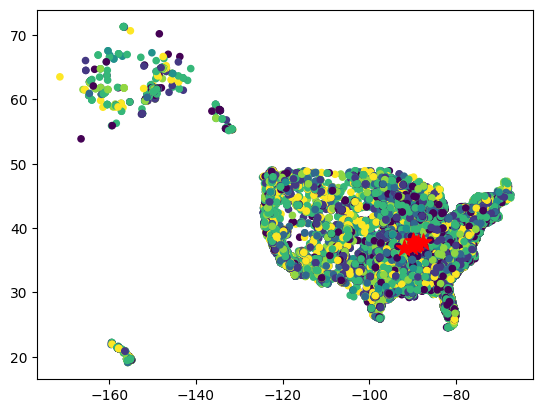

In [ ]:
plt.scatter(numeric_dataset['longitude'], numeric_dataset['latitude'],  c=kmeans.labels_, s=20)
plt.scatter(centers_df['longitude'], centers_df['latitude'], marker='*', c='r', s=150)
#plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

FROM HERE ONWARDS IT'S OLD STUFF, JUST FOR REFERENCE

## Characterization of obtained clusters

### Analysis of K centroids

* Coordinate values
* Number of points per cluster (Check that there aren't centroids of empty clusters)
* Plotting centroids:
    * On map, longitude and latitude (partito per il colore per i centroidi)
* Visualization with:
    * Two features with most variance
    * PCA, tSNE plot, isomap?
* Cluster separation evaluation
    * Min, max, mean distance between centroids (or matrix of distances)
* Evaluate compactness of clusters (SSE, variance, ... per cluster, both mean and sum)
* Check if there are centroids influenced a lot by outliers
* Correlation Analysis: analyze correlation between value of attribute and assignment to clusters

In [ ]:
print("Shape of centers:", centers.shape)
print("Attributes of centers:", centers.columns.values)
centers.head()

Shape of centers: (30, 22)
Attributes of centers: ['month' 'year' 'latitude' 'longitude' 'congressional_district'
 'state_house_district' 'state_senate_district' 'min_age_participants'
 'avg_age_participants' 'max_age_participants' 'children_ratio'
 'teen_ratio' 'adults_ratio' 'males_ratio' 'females_ratio' 'killed_ratio'
 'injured_ratio' 'arrested_ratio' 'unharmed_ratio' 'n_participants'
 'povertyPercentage' 'votes_ratio']


,month,year,latitude,longitude,congressional_district,state_house_district,state_senate_district,min_age_participants,avg_age_participants,max_age_participants,...,adults_ratio,males_ratio,females_ratio,killed_ratio,injured_ratio,arrested_ratio,unharmed_ratio,n_participants,povertyPercentage,votes_ratio
0,3.854798,2014.660221,37.407408,-87.877122,7.785966,47.047428,17.438404,11.151648,11.443999,11.753983,...,0.990731,0.988496,0.007897,0.018471,0.966838,0.004034,0.006971,1.337468,13.420990,0.695135
1,9.471141,2015.923370,38.538825,-89.305130,7.346707,45.447370,18.424782,26.404097,27.150831,28.053122,...,0.989287,0.984089,0.010553,0.008032,0.009214,0.974063,0.010107,1.502265,12.100204,0.587643
2,6.237948,2016.508688,41.771153,-91.285553,0.708800,8.022982,4.044563,0.735706,0.767096,0.804372,...,0.016247,0.048226,0.011771,0.016797,0.025776,0.033618,0.043508,0.376962,12.028587,0.000761
3,6.554560,2016.022649,36.563801,-89.564400,6.929736,46.696094,17.327864,25.473626,29.833702,34.552547,...,0.928448,0.964897,0.016968,0.452531,0.044265,0.488442,0.011992,2.408798,13.040457,0.595546
4,3.207436,2014.887859,37.299432,-88.320114,7.985321,49.185658,17.932619,7.906148,8.222236,8.574058,...,0.975838,0.947266,0.016359,0.014247,0.021814,0.006645,0.951805,2.069426,13.415281,0.627546


Choose some variables because you can't read the graph with 20+ variables.

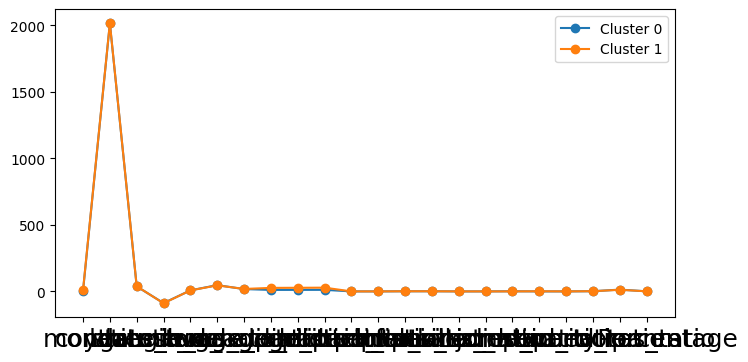

In [ ]:
plt.figure(figsize=(8, 4))
for i in range(0, 2):
    plt.plot(centers.values[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(numeric_dataset.columns)), numeric_dataset.columns, fontsize=18)
plt.legend(fontsize=10)
plt.show()

### Distribution of variables: within clusters vs whole dataset

Analysis of distribution of some variables:

* Table with:
    * Whole dataset variance
    * Variance of cluster with min variance
    * Variance of cluster with max variance
    * Mean of variances of clusters
* Plot with the distribution of:
    * Var in whole dataset
    * Var in cluster with least amount of variance
    * Var in cluster with max amount of variance


Evaluation of clustering results:
* Similarity Matrix (Correlation proximity-ideal)
* Ordered similarity matrix (blockwise inspection)
* SSE
* Cohesion and separation
* Silhouette
* Davis Boulding Index

# Best Clustering Approach